# Initialization

In [10]:
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from qiskit.tools.monitor import job_monitor
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit import Aer, execute, IBMQ
from qiskit.extensions import UnitaryGate

import sys
import os
import time
import functools
import IPython.display
 
from lib.utils import *
from lib.U_layer import *
from lib.P_layer import *

%load_ext autoreload
%autoreload 2
# %matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
interest_num = [3,6]
ori_img_size = 28
img_size = 4
# number of subprocesses to use for data loading
num_workers = 8
# how many samples per batch to load
batch_size = 1
inference_batch_size = 1
data_path = './data'

qc_shots = 8192

# convert data to torch.FloatTensor
transform = transforms.Compose([transforms.Resize((ori_img_size,ori_img_size)),
                                transforms.ToTensor()])
# Path to MNIST Dataset
train_data = datasets.MNIST(root=data_path, train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root=data_path, train=False,
                                  download=True, transform=transform)

train_data = select_num(train_data,interest_num)
test_data =  select_num(test_data,interest_num)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=inference_batch_size, 
    num_workers=num_workers, shuffle=True, drop_last=True)



# Model initialization
weight_1_1 = torch.tensor([1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,    1.,  1.])
weight_1_2 = torch.tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1., -1.,-1., -1.])

weight_2_1 = torch.tensor([1.,  -1.])
norm_flag_1 = True
norm_para_1 = torch.tensor(0.3060)

weight_2_2 = torch.tensor([-1.,  -1.])
norm_flag_2 = False
norm_para_2 = torch.tensor(0.6940)

weights = [weight_1_1, weight_1_2, weight_2_1, weight_2_2]
flags = [norm_flag_1, norm_flag_2]
params = [norm_para_1, norm_para_2]

weights_1 = [weight_1_1, weight_2_1]
weights_2 = [weight_1_2, weight_2_2]

# Model

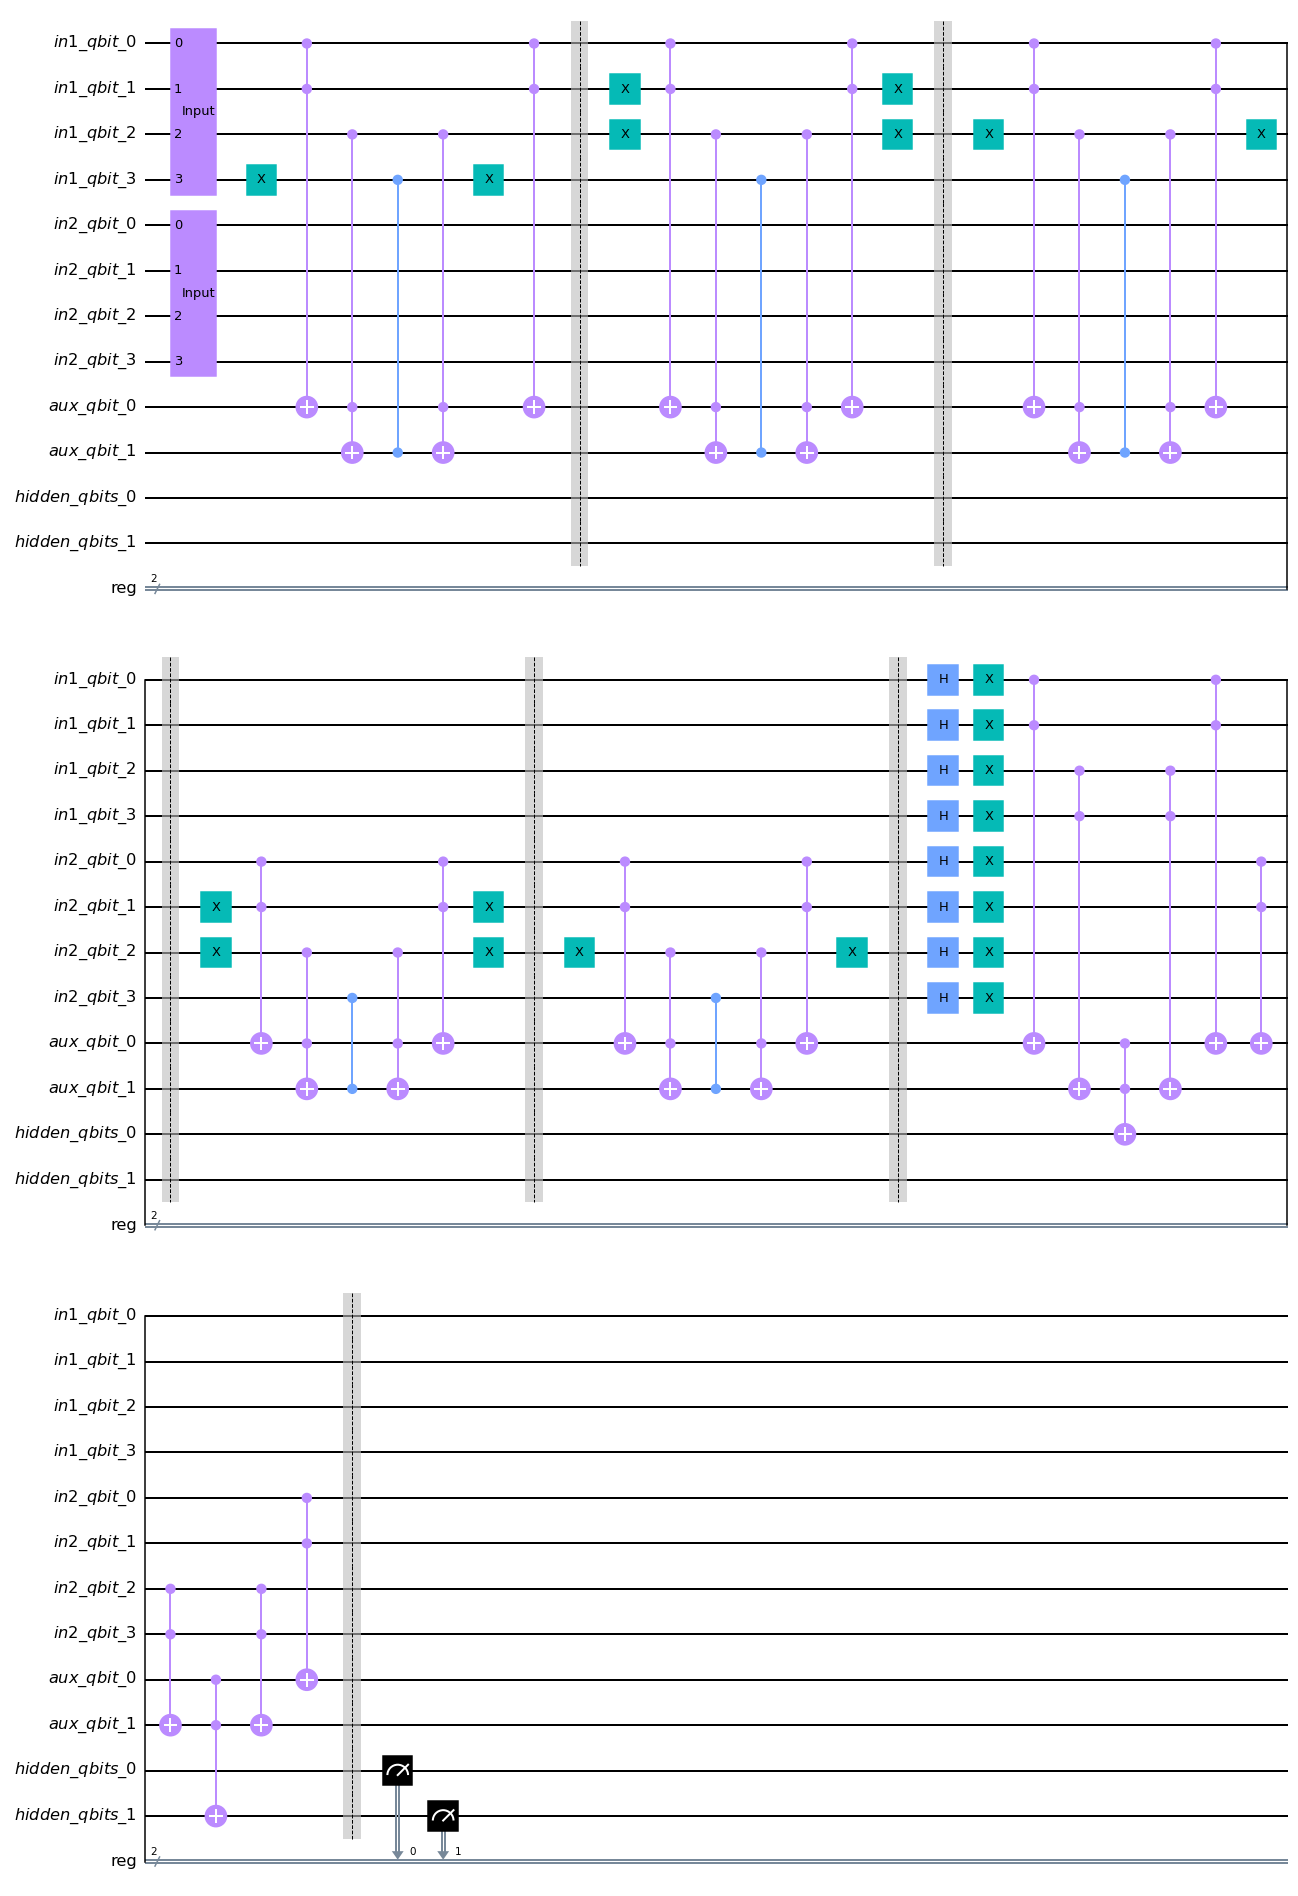

In [12]:
for batch_idx, (data, target) in enumerate(test_loader):

    torch.set_printoptions(threshold=sys.maxsize)
    # print("Batch Id: {}, Target: {}".format(batch_idx,target))
    quantum_matrix, qantum_data = data_pre_pro(
        torchvision.utils.make_grid(data), img_size, verbose=False)

    p_circ = p_circ_gen(quantum_matrix, weights, flags, params, batch_norm=False)
    break

p_circ.draw("mpl")

In [16]:
max_itr = 100
saving = True
simulation = True

p_pred = []
u_pred = []
p_prob = []
u_prob = []
itr = 0

for batch_idx, (data, target) in enumerate(test_loader):

    torch.set_printoptions(threshold=sys.maxsize)
    # print("Batch Id: {}, Target: {}".format(batch_idx,target))
    quantum_matrix, qantum_data = data_pre_pro(
        torchvision.utils.make_grid(data), img_size, verbose=False)

    p_circ = p_circ_gen(quantum_matrix, weights, flags, params, batch_norm=False)
    # u_circ = u_circ_gen(quantum_matrix, weights, flags, params, batch_norm=False)

    # p_circ
    counts = fire_ibmq(p_circ, qc_shots, Simulation=simulation)
    (mycount, bits) = analyze(counts)
    class_prob = []
    for b in range(bits):
        class_prob.append(float(mycount[b])/qc_shots)
    
    p_prob.append(class_prob)
    # result = abs((class_prob.index(max(class_prob)) - target[0]).numpy()) # 0 if correct, 1 if not
    # p_pred.append(result)

    # u_circ
    # opt_counts = fire_ibmq(u_circ, qc_shots, Simulation=simulation)
    # (opt_mycount, bits) = analyze(opt_counts)
    # opt_class_prob = []
    # for b in range(bits):
    #     opt_class_prob.append(float(opt_mycount[b])/qc_shots)

    # u_prob.append(opt_class_prob)
    # result = abs((opt_class_prob.index(max(opt_class_prob)) - target[0]).numpy())
    # u_pred.append(result)


    itr += 1
    IPython.display.clear_output(wait=True)
    print("iterantion", itr, "out of", min(max_itr, len(test_loader)))
    print("="*30)
    print("Circuit Depth:", p_circ.depth())
    print("Result:", class_prob)
    print("Prediction class: {}".format(class_prob.index(max(class_prob))))
    print("Target class: {}".format(target[0]))
    if class_prob.index(max(class_prob)) == target[0]:
        print("Correct prediction")
        result = 0
    else:
        print("Incorrect prediction")
        result = 1
    p_pred.append(result)
    if itr >= max_itr:
        break
    
if saving:
    t = time.localtime()
    dir = "./results/noBN_"+time.strftime('%m-%d_%H-%M', t)

    if not os.path.exists(dir):
        os.makedirs(dir)

    # df_pred = pd.DataFrame([p_pred, u_pred])
    df_pred = pd.DataFrame(p_pred)
    df_pred.to_csv(dir+"/predictions.csv", index=False)

    dfp = pd.DataFrame(p_prob, columns=["p[0]", "p[1]"])
    # dfu = pd.DataFrame(u_prob, columns=["u[0]", "u[1]"])
    dfp.to_csv(dir+"/probilities.csv", index=False)

iterantion 100 out of 100
Circuit Depth: 39
Result: [0.2418212890625, 0.253662109375]
Prediction class: 1
Target class: 0
Incorrect prediction


In [18]:
data_path = "results\\noBN_08-03_18-05"

df_pred = pd.read_csv(data_path + '\\predictions.csv')
p_pred = df_pred.iloc[:, 0].to_numpy()

df_prob = pd.read_csv(data_path + "\\probilities.csv")
p_prob = df_prob.iloc[:, 0:2].to_numpy()

p_acc = 1 - p_pred.sum()/p_pred.shape[0]
print(p_acc)

0.47


In [ ]:
p_prob

array([[0.13098145, 0.15490723],
       [0.30895996, 0.34631348],
       [0.30480957, 0.38171387],
       [0.24047852, 0.24560547],
       [0.08239746, 0.10583496],
       [0.22900391, 0.23254395],
       [0.25793457, 0.26037598],
       [0.20458984, 0.22033691],
       [0.13183594, 0.1328125 ],
       [0.09729004, 0.1048584 ],
       [0.34960938, 0.36120605],
       [0.31103516, 0.32629395],
       [0.13256836, 0.12866211],
       [0.32641602, 0.36755371],
       [0.10754395, 0.1237793 ],
       [0.23181152, 0.23510742],
       [0.30957031, 0.32348633],
       [0.12536621, 0.14526367],
       [0.07739258, 0.16796875],
       [0.31628418, 0.38562012],
       [0.28625488, 0.36755371],
       [0.078125  , 0.1027832 ],
       [0.2989502 , 0.30285645],
       [0.08251953, 0.0982666 ],
       [0.23718262, 0.27429199],
       [0.09667969, 0.12646484],
       [0.05664062, 0.14404297],
       [0.10046387, 0.109375  ],
       [0.21337891, 0.22338867],
       [0.12109375, 0.15966797],
       [0.